# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from start
read_post_muncipalities  read from file
read_stats_postcode  read from file
read_ravintolat_ja_kaupat  read from file
read_kiinteisto  read from file
read_vaalit  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=False)

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd

from draw_and_create_clusters import create_kmeans_clusters 

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data

from draw_and_create_clusters import draw_pca, drawTSNE,  display_scree_plot, display_circles, display_parallel_coordinates_centroids, display_factorial_planes
from delete_outliers import delete_outliers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the TensorBoard notebook extension
%load_ext tensorboard

pd.options.display.max_colwidth = 100


selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

selected = stat[(stat['muncipality_code']==49)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==49)].copy()
post_included = post[post['muncipality_code']==49]['postcode'].copy()


selected = stat[(stat['muncipality_code']==91)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91)].copy()
post_included = post[post['muncipality_code']==91]['postcode'].copy()

selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[vaalidata['area_code']=='FI1B1'].copy()
post_included = post[post['area_code']=='FI1B1'].copy()

selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

In [5]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif


data, X, X_scale = prepare_and_scale_data(selected, pd.DataFrame(), numeric_features, categorical_features)

from create_prediction import create_prediction
values = data.sort_values(by=['Suurin_puolue numero'])['Suurin_puolue numero'].unique()
j = 0
for i in values:
    j = j + 1
    data.loc[data['Suurin_puolue numero']==i, 'Suurin_puolue numero uusi numero'] = j

data.loc[:,'Suurin_puolue numero uusi numero'] = data['Suurin_puolue numero uusi numero'].astype(int) 
target = 'Suurin_puolue numero uusi numero'

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['Suurin_puolue numero uusi numero'].unique()) + 1 #how many classes we are working with

metric = 'merror'
Skfold=False
Verbose = False
testing=True

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
} 

data, test, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test = create_prediction(data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=False, testing=True)

from reset_party_number import reset_party_number
data, class_names = reset_party_number(data)

[0]	train-merror:0.18266	test-merror:0.32492
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 10 rounds.
Stopping. Best iteration:
[34]	train-merror:0.00000	test-merror:0.25589

testing
Start with xgb.cv params: merror: 0.2714646666666667
Best xgb.cv params: max_depth 6, min_child_weight 3, merror: 0.2571546666666667
Best xgb.cv params: gamma 1.0, merror: 0.25589199999999995
Best xgb.cv params: lambda 1.0, alpha 0.0, merror: 0.25589199999999995
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, merror: 0.25589199999999995
Best xgb.cv params: eta 0.4, merror: 0.26599333333333336
Best xgb.cv params: max_depth 7, min_child_weight 4, merror: 0.25968033333333335
Best xgb.cv params: gamma 1.0, merror: 0.25968033333333335
Best xgb.cv params: lambda 0.8, alpha 0.6, merror: 0.25547133333333333
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, merror: 0.25547133333333333
Best xgb.cv params: eta 0.

In [6]:
from shap_tree import shap_tree
explainer, shap_values, shap_interaction_values, shap_expected_value  = shap_tree(X, data[target], params)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


invalid value encountered in true_divide
invalid value encountered in true_divide


Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

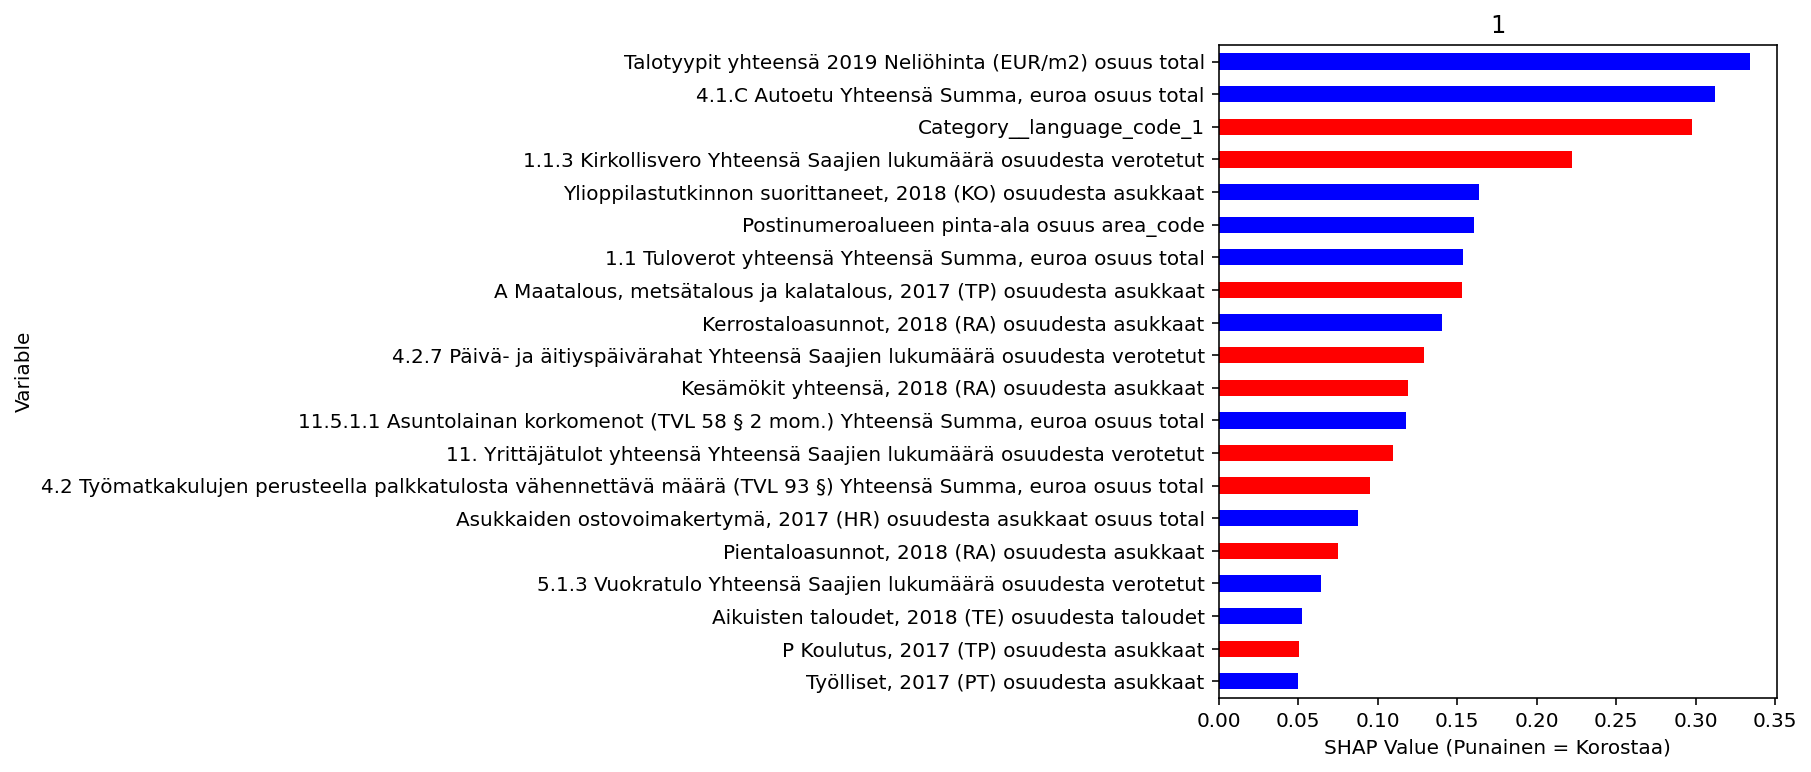

In [10]:
idx=1
from shap_vals import shap_vals
k = shap_vals(X, shap_values[idx])
k2 = k.tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= idx, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")


In [19]:
data['prop'] = np.where(data['Suurin_puolue']==data['Ennustettu Suurin_puolue nimi'],True, False)

In [24]:
data[(data['prop']==False) & (data['Ennustettu Suurin_puolue nimi']=='KOK')]

,Postinumero,"0-2-vuotiaat, 2018 (HE)","13-15-vuotiaat, 2018 (HE)","16-17-vuotiaat, 2018 (HE)","18 vuotta täyttäneet yhteensä, 2017 (HR)","18 vuotta täyttäneet yhteensä, 2018 (KO)","18-19-vuotiaat, 2018 (HE)","20-24-vuotiaat, 2018 (HE)","25-29-vuotiaat, 2018 (HE)","3-6-vuotiaat, 2018 (HE)",...,Postinumeroalueen pinta-ala osuus area_code,Suurin_puolue,Suurin_puolue numero,Äänestysosuus,Suurin_puolue numero uusi numero,Ennustettu Suurin_puolue numero uusi numero,Ennustettu Suurin_puolue nimi,Ennustettu Suurin_puolue numero,Ennustettu puoluevari,prop
45,00630,245.0,220.0,105.0,6906.0,6872.0,136.0,379.0,613.0,359.0,...,0.000266,VIHR,9,0.754827,8,6.0,SDP,7,pink,False
59,00770,319.0,243.0,152.0,5757.0,5930.0,153.0,587.0,678.0,398.0,...,0.000375,PS,5,0.633274,4,6.0,SDP,7,pink,False
121,01760,51.0,81.0,61.0,1623.0,1606.0,47.0,67.0,55.0,87.0,...,0.003491,PS,5,0.743813,4,6.0,SDP,7,pink,False
224,09120,22.0,39.0,28.0,975.0,971.0,27.0,32.0,39.0,57.0,...,0.012124,KESK,3,0.733122,2,6.0,SDP,7,pink,False
432,12700,37.0,97.0,55.0,1907.0,1859.0,44.0,76.0,71.0,56.0,...,0.013678,KOK,4,0.690909,3,6.0,SDP,7,pink,False
448,36600,93.0,128.0,83.0,2726.0,2681.0,73.0,109.0,128.0,149.0,...,0.011191,KOK,4,0.693927,3,6.0,SDP,7,pink,False
495,16730,27.0,35.0,27.0,765.0,774.0,32.0,30.0,19.0,46.0,...,0.010905,PS,5,0.770202,4,6.0,SDP,7,pink,False
505,16300,267.0,379.0,232.0,8495.0,8468.0,211.0,413.0,500.0,458.0,...,0.039044,PS,5,0.618249,4,6.0,SDP,7,pink,False
773,25630,3.0,4.0,7.0,234.0,232.0,1.0,6.0,2.0,11.0,...,0.001663,KOK,4,0.740113,3,6.0,SDP,7,pink,False
845,28300,65.0,102.0,69.0,1989.0,2005.0,59.0,96.0,118.0,109.0,...,0.000281,KOK,4,0.774393,3,6.0,SDP,7,pink,False


In [8]:
from OrderedSet import OrderedSet
k= []
i=0
for t in data[target].unique():
    vals = shap_vals(X, shap_values[i])
    k.extend(vals['Variable'].tail(1).to_list())
    i = i + 1
k = list(dict.fromkeys(k))
new = ['Postinumero','muncipality_name','Asukkaat yhteensä, 2018 (HE)', 'Suurin_puolue']
new_x = list(OrderedSet(X.columns.to_list())- (OrderedSet(X.columns.to_list())-OrderedSet(k)))
new_df=pd.concat([data[new],X[new_x]], axis=1)

In [9]:
show_df = new_df[new_df['Suurin_puolue']=='RKP'].sample(n=5).copy()
from IPython.display import HTML
import numpy as np
show_df = np.round(show_df,2)
HTML(show_df.to_html(index=False))

Postinumero,muncipality_name,"Asukkaat yhteensä, 2018 (HE)",Suurin_puolue,Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total,"Asumisväljyys, 2018 (TE) osuus total","Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat","Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat",1.1.3 Kirkollisvero Yhteensä Saajien lukumäärä osuudesta verotetut,11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut,"11.5.1.1 Asuntolainan korkomenot (TVL 58 § 2 mom.) Yhteensä Summa, euroa osuus total",Category__language_code_1
07750,Loviisa,532.0,RKP,0.09,0.35,0.10,-0.28,-0.01,-0.33,1.22,0
68500,Kruunupyy,2837.0,RKP,-0.35,0.20,-0.08,0.02,0.93,0.11,0.35,0
02700,Kauniainen,9484.0,RKP,2.67,0.39,2.09,4.84,-1.05,-0.85,1.68,0
04130,Sipoo,7503.0,RKP,0.80,-0.08,0.82,1.08,-0.43,-0.75,1.04,0
66220,Maalahti,458.0,RKP,-0.02,0.75,-0.24,0.19,0.48,-0.49,0.82,0
